In [12]:
import pandas as pd
import numpy as np
import os


import torch
import torch.nn as nn
import os
import itertools
import json
import traceback

from datetime import datetime
from tqdm import tqdm
from pathlib import Path
from dotenv import load_dotenv
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from classification_rnn import ClassificationRNN, DEVICE



In [ ]:
BASE = "../../data/aisdk/processed"


In [ ]:
# df = pd.read_parquet("traj.parquet")
# df.loc[df["ClusterLabel"] == -1, "ClusterLabel"] = 3
# print(df["ClusterLabel"].value_counts())
# df.to_parquet("traj2") # doesnt work

ClusterLabel
3    1820
Name: count, dtype: int64


In [ ]:
# df = pd.read_parquet("traj.parquet")
# print(df["ClusterLabel"].value_counts())

ClusterLabel
 3    1616
-1     204
Name: count, dtype: int64


# 1 - Create the windows

In [ ]:
def make_past_future_windows_np(
    past_len=30,
    future_len=30,
    step=1,
    input_path="traj.parquet",
    output_path="data/aisdk/processed/windows/train_trajectories.npz"
):
    """
    Load standardized, sorted trajectory data from an npz file,
    create past/future sliding windows, and save everything as NumPy arrays
    in a single .npz file:

        - past:    (N, past_len, num_features)
        - future:  (N, future_len, num_features)
        - traj_id: (N,) - original trajectory ID for each window

    """
    print(f"Loading trajectories from {input_path} ...")
    df = pd.read_parquet(input_path)

    df = df.sort_values(["Trajectory", "Timestamp"])


    feature_cols = ['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']
    grouped = df.groupby(["Trajectory", "ClusterLabel"])

    num_traj = len(grouped)
    print(f"Total trajectory segments: {num_traj}\n")

    processed_segments = 0
    total_windows = 0

    print(f"  → Found {num_traj} trajectories")
    print(f"  → Features: {feature_cols}")

    total_len = past_len + future_len

    past_list = []
    future_list = []
    traj_list = []
    cluster_list = []
    processed_segments = 0

    for (traj, cid), g in grouped:
        
        processed_segments += 1
        T = g.shape[0]
        if T < total_len:
            continue  # too short for one window

        # number of windows for this trajectory (with stride `step`)
        num_windows = (T - total_len) // step + 1
        total_windows += num_windows
        
        # Change to numerical features
        feats = g[feature_cols].to_numpy(dtype=float)

        for w in range(num_windows):
            start = w * step
            mid   = start + past_len
            end   = mid + future_len

            past_window = feats[start:mid]   # (past_len, F)
            future_window = feats[mid:end]   # (future_len, F)

            past_list.append(past_window)
            future_list.append(future_window)
            traj_list.append(traj)
            cluster_list.append(cid)

        if (processed_segments + 1) % 500 == 0:
            print(f"  → Processed {i+1}/{num_traj} trajectories, {len(past_list)} windows so far")

    if not past_list:
        raise RuntimeError("No windows generated. "
                            "Check past_len, future_len, and trajectory lengths.")

    print("Stacking windows into numpy arrays...")
    past = np.stack(past_list)     # (N, past_len, F)
    future = np.stack(future_list) # (N, future_len, F)
    traj_id = np.array(traj_list)  # (N,)
    cluster = np.array(cluster_list)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    print(f"Saving windows to {output_path} ...")
    np.savez_compressed(
        output_path,
        past=past,
        future=future,
        cluster=cluster,
        traj_id=traj_id,
        feature_cols=feature_cols,
        past_len=past_len,
        future_len=future_len,
        step=step,
    )

    print("\nDONE!")
    print(f"  → Total windows: {past.shape[0]:,}")
    print(f"  → Shape - past: {past.shape}, future: {future.shape}")
    print(f"  → Output saved to: {output_path}")

    # Summary statistics
    unique_trajs = np.unique(traj_id)
    print(f"  → Windows span {len(unique_trajs)} unique trajectories")
    print(f"  → Avg windows per trajectory: {len(past_list) / len(unique_trajs):.1f}")

In [ ]:
make_past_future_windows_np(
    input_path=os.path.join(BASE, "train_trajectories.npz"),
    output_path=os.path.join(BASE, "windows/train_trajectories.npz"),
)

make_past_future_windows_np(
    input_path  = os.path.join(BASE, "val_trajectories.npz"),
    output_path = os.path.join(BASE, "windows/val_trajectories.npz"),
)

make_past_future_windows_np(
    input_path  = os.path.join(BASE, "test_trajectories.npz"),
    output_path = os.path.join(BASE, "windows/test_trajectories.npz")
)

Loading trajectories from traj2.parquet ...
Total trajectory segments: 2

  → Found 2 trajectories
  → Features: ['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']
Stacking windows into numpy arrays...
Saving windows to ../../data/aisdk/processed/windows/train_trajectories.npz ...

DONE!
  → Total windows: 1,702
  → Shape - past: (1702, 30, 5), future: (1702, 30, 5)
  → Output saved to: ../../data/aisdk/processed/windows/train_trajectories.npz
  → Windows span 2 unique trajectories
  → Avg windows per trajectory: 851.0
Loading trajectories from traj2.parquet ...
Total trajectory segments: 2

  → Found 2 trajectories
  → Features: ['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']
Stacking windows into numpy arrays...
Saving windows to ../../data/aisdk/processed/windows/val_trajectories.npz ...

DONE!
  → Total windows: 1,702
  → Shape - past: (1702, 30, 5), future: (1702, 30, 5)
  → Output saved to: ../../data/aisdk/processed/windows/val_trajectories.npz
  → Windows span 2 unique trajectories


# 1 - Fetch the data

In [18]:
train_traj = np.load(os.path.join(BASE, "windows/train_trajectories.npz"))
val_traj = np.load(os.path.join(BASE, "windows/val_trajectories.npz"))
test_traj = np.load(os.path.join(BASE, "windows/test_trajectories.npz"))

X_train, X_val = train_traj["past"], val_traj["past"]
y_train, y_val = train_traj["cluster"], val_traj["cluster"]

# %% Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)

# Create data loaders
print(f"\nTensor shapes:")
print(f"  X_train_t: {X_train_t.shape}")
print(f"  X_val_t:   {X_val_t.shape}")
print(f"  y_train_t: {y_train_t.shape}")
print(f"  y_val_t:   {y_val_t.shape}")

# %% Create data loaders
def make_loaders(batch_size):
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


Tensor shapes:
  X_train_t: torch.Size([1702, 30, 5])
  X_val_t:   torch.Size([1702, 30, 5])
  y_train_t: torch.Size([1702])
  y_val_t:   torch.Size([1702])


# 2 - Train
## 2.1 - Define functions for one run

In [ ]:
def _train_one_run(cfg, train_loader, val_loader):
    
    device = cfg["device"]

    model = ClassificationRNN(
        input_size=cfg["input_size"],
        hidden_size=cfg["hidden_size"],
        num_classes=cfg["num_classes"], 
    ).to(device)

    opt = torch.optim.Adam(
        model.parameters(), 
        lr=cfg["lr"], 
        weight_decay=cfg["weight_decay"]
    )

    crit = nn.CrossEntropyLoss()

    best_val_loss = float("inf")

    train_losses = []
    train_accs     = []
    val_losses   = []
    val_accs     = []

    # %% Training loop
    for epoch in range(cfg["epochs"]):
    
        # ------ Training phase ------
        model.train()
        train_loss_total = 0.0
        train_correct = 0
        train_samples = 0
        
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg['epochs']} [Train]"):
            xb = xb.to(device)  # (B, seq_len, num_features)
            yb = yb.to(device)  # (B,)

            opt.zero_grad()
            logits = model(xb)  # (B, num_classes)
            loss = crit(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg["grad_clip"])
            opt.step()

            train_loss_total += loss.item() #* xb.size(0)

            # Calculate accuracy
            preds = logits.argmax(dim=1)  # (B,)
            train_correct += (preds == yb).sum().item()
            train_samples += yb.size(0)

        train_loss = train_loss_total / len(train_loader)
        train_acc = train_correct / train_samples if train_samples > 0 else 0.0

        # ------ Validation ------
        model.eval()
        val_loss_total = 0.0
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg['epochs']} [Val]"):
                xb = xb.to(device)
                yb = yb.to(device)

                logits = model(xb)
                loss = crit(logits, yb)
                val_loss_total += loss.item() #*xb.size(0)

                preds = logits.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_samples += yb.size(0)

        val_loss = val_loss_total / len(val_loader)
        val_acc = val_correct / val_samples if val_samples > 0 else 0.0

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"  → New best validation loss: {best_val_loss:.4f}")
        
    return model, train_losses, val_losses, train_accs, val_accs


## 2.2 - Hyperparameter tuning

In [20]:
# Define key metrics
input_size = X_train.shape[-1]
n_classes = int(y_train.max() + 1)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
def hyperparameter_search_classification(
    device=device,
    input_size=input_size,
    num_classes=n_classes,
    search_type='grid',
    save_dir='../../checkpoints/hyperparameter_results_classification'
):
    os.makedirs(save_dir, exist_ok=True)
    
    print("="*70)
    print("HYPERPARAMETER TUNING FOR CLASSIFICATION RNN")
    print("="*70)
    
    # -------- 1) Define search space --------
    if search_type == 'grid':
        param_grid = {
            # Tune these:
            'hidden_size'   : [64, 128],
            'num_layers'    : [1, 2],
            'dropout'       : [0.0, 0.3],
            'lr'            : [1e-4, 3e-4, 1e-3],
            'weight_decay'  : [0.0, 1e-4],
            
            # Fixed:
            'batch_size'    : [256],
            'epochs'        : [20],
            #'patience'     : [5],
            #'min_delta'    : [1e-4],
            'grad_clip'     : [1.0],
        }

        # total combos: 2 * 2 * 2 * 3 = 24
        
    elif search_type == 'quick':
        # Smaller search – good for smoke-testing
        param_grid = {
            'hidden_size'   : [64, 128],
            'num_layers'    : [1],
            'dropout'       : [0.0, 0.3],
            'lr'            : [3e-4],
            'weight_decay'  : [0.0, 1e-4],

            
            'batch_size'    : [256],
            'epochs'        : [15],
            #'patience'     : [3],
            #'min_delta'    : [1e-4],
            'grad_clip'     : [1.0],
        }
        # total combos: 2 * 1 * 2 * 1 = 4
        
    else:
        raise ValueError(f"Unknown search_type: {search_type}")
    
    # Generate combinations
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    combinations = list(itertools.product(*values))
    param_combinations = [dict(zip(keys, combo)) for combo in combinations]
    
    print(f"{search_type.capitalize()} Search: {len(param_combinations)} combinations")
    # super rough estimate: 5 min / combo like your friend
    print(f"Estimated time: {len(param_combinations) * 5} minutes")
    print("="*70)
    
    # -------- 2) Tracking --------
    results = []
    best_score = float('inf')   # here: best_val_loss
    best_params = None
    start_time = datetime.now()
    
    # -------- 3) Main search loop --------
    for idx, params in enumerate(param_combinations):
        print(f"\n{'='*70}")
        print(f"Trial {idx+1}/{len(param_combinations)}")
        elapsed_min = (datetime.now() - start_time).total_seconds() / 60
        print(f"Time elapsed: {elapsed_min:.1f} min")
        print(f"{'='*70}")
        
        print("Testing config:")
        print(f"  hidden_size   = {params['hidden_size']}")
        print(f"  num_layers    = {params['num_layers']}")
        print(f"  dropout       = {params['dropout']}")
        print(f"  lr            = {params['lr']}")
        print(f"  weight_decay  = {params['weight_decay']}")
        print(f"  batch_size    = {params['batch_size']}")
        print(f"  epochs        = {params['epochs']}")
        print()
        
        try:
            # ---- Build config dict for your existing _train_one_run ----
            cfg = {
                "device": device,
                "input_size": input_size,
                "num_classes": num_classes,
                
                # training hyperparams
                "hidden_size": params["hidden_size"],
                "num_layers": params["num_layers"],
                "dropout"   : params["dropout"],
                "lr"        : params["lr"],
                "weight_decay": params["weight_decay"],
                "batch_size": params["batch_size"],
                "epochs"    : params["epochs"],
                #"patience": params["patience"],
                #"min_delta": params["min_delta"],
                "grad_clip": params["grad_clip"],
            }
            
            train_loader, val_loader = make_loaders(cfg["batch_size"])

            model, train_losses, val_losses, train_accs, val_accs = _train_one_run(cfg, train_loader, val_loader)
            
            # ---- Extract metrics ----
            val_losses = list(val_losses)
            best_val_loss = float(min(val_losses))
            best_epoch = int(val_losses.index(best_val_loss) + 1)
            
            if val_accs is not None:
                val_accs = list(val_accs)
                best_val_acc = float(val_accs[best_epoch - 1])
            else:
                best_val_acc = float("nan")
            
            final_train_loss = float(train_losses[best_epoch - 1])
            overfit_ratio = best_val_loss / max(final_train_loss, 1e-6)
            
            score = best_val_loss  # primary metric: lower is better
            
            result = {
                **params,
                'best_val_loss': best_val_loss,
                'best_val_acc': best_val_acc,
                'best_epoch': best_epoch,
                'final_train_loss': final_train_loss,
                'overfit_ratio': overfit_ratio,
                'score': score,
                'trial': idx + 1,
            }
            results.append(result)
            
            print(f"\nResults:")
            print(f"  Best Val Loss: {best_val_loss:.4f} (epoch {best_epoch})")
            if not np.isnan(best_val_acc):
                print(f"  Best Val Acc : {best_val_acc:.4f}")
            print(f"  Train Loss @best: {final_train_loss:.4f}")
            print(f"  Overfit ratio: {overfit_ratio:.2f}")
            print(f"  Score (val_loss): {score:.4f}")
            
            if score < best_score:
                best_score = score
                best_params = params.copy()
                print(f"  ⭐ NEW BEST CONFIG FOUND!")
                
                
                # Save best model
                torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            
            # Clean up
            del model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        except Exception as e:
            print(f"  ❌ FAILED: {str(e)}")
            traceback.print_exc()
            result = {**params, 'error': str(e), 'trial': idx + 1}
            results.append(result)
    
    # -------- 4) Save & summarize --------
    if len(results) == 0:
        print("\n❌ No trials completed!")
        return None, None
    
    df = pd.DataFrame(results)
    
    # Sort by score (val loss)
    if 'score' in df.columns:
        df = df.sort_values('score', na_position='last')
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = os.path.join(save_dir, f"results_{timestamp}.csv")
    df.to_csv(csv_path, index=False)
    
    if best_params is None:
        print("\n❌ All trials failed! Check error messages above.")
        return df, None
    
    json_path = os.path.join(save_dir, f"best_params_{timestamp}.json")
    with open(json_path, 'w') as f:
        json.dump(best_params, f, indent=2)
    
    total_time = (datetime.now() - start_time).total_seconds() / 60
    print(f"\n{'='*70}")
    print("HYPERPARAMETER SEARCH COMPLETE")
    print("="*70)
    print(f"Total time: {total_time:.1f} minutes")
    successful = [r for r in results if 'error' not in r]
    print(f"Successful trials: {len(successful)}/{len(results)}")
    
    print(f"\nBest parameters (score={best_score:.4f}):")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    
    print(f"\nResults saved to: {csv_path}")
    print(f"Best params saved to: {json_path}")
    print(f"Best model saved to: {os.path.join(save_dir, 'best_model.pth')}")
    
    # Show top 5 successful trials
    successful_df = df[df['score'].notna()]
    top_cols = [
        'hidden_size', 'num_layers', 'dropout', 'lr',
        'batch_size', 'best_val_loss', 'best_val_acc', 'score'
    ]
    print("\nTop 5 configurations:")
    print(successful_df[top_cols].head())
    
    return df, best_params


In [22]:
# Run the training
df_cls, best_params_cls = hyperparameter_search_classification(
    device=device,
    input_size=input_size,
    num_classes=n_classes,
    search_type='grid',
    save_dir='../../checkpoints/hyperparameter_results_classification' 
)

HYPERPARAMETER TUNING FOR CLASSIFICATION RNN
Grid Search: 48 combinations
Estimated time: 240 minutes

Trial 1/48
Time elapsed: 0.0 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


  → New best validation loss: 1.1515

Results:
  Best Val Loss: 1.1515 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 1.2025
  Overfit ratio: 0.96
  Score (val_loss): 1.1515
  ⭐ NEW BEST CONFIG FOUND!

Trial 2/48
Time elapsed: 0.1 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]


  → New best validation loss: 1.2536

Results:
  Best Val Loss: 1.2536 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.2541
  Overfit ratio: 1.00
  Score (val_loss): 1.2536

Trial 3/48
Time elapsed: 0.1 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]


  → New best validation loss: 1.2205

Results:
  Best Val Loss: 1.2205 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.2269
  Overfit ratio: 0.99
  Score (val_loss): 1.2205

Trial 4/48
Time elapsed: 0.2 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


  → New best validation loss: 0.8340

Results:
  Best Val Loss: 0.8340 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.8369
  Overfit ratio: 1.00
  Score (val_loss): 0.8340
  ⭐ NEW BEST CONFIG FOUND!

Trial 5/48
Time elapsed: 0.3 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]


  → New best validation loss: 1.1893

Results:
  Best Val Loss: 1.1893 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.2005
  Overfit ratio: 0.99
  Score (val_loss): 1.1893

Trial 6/48
Time elapsed: 0.3 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


  → New best validation loss: 1.1907

Results:
  Best Val Loss: 1.1907 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.4517
  Overfit ratio: 0.82
  Score (val_loss): 1.1907

Trial 7/48
Time elapsed: 0.4 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]


  → New best validation loss: 1.0142

Results:
  Best Val Loss: 1.0142 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 1.0251
  Overfit ratio: 0.99
  Score (val_loss): 1.0142

Trial 8/48
Time elapsed: 0.5 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


  → New best validation loss: 0.5844

Results:
  Best Val Loss: 0.5844 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.5851
  Overfit ratio: 1.00
  Score (val_loss): 0.5844
  ⭐ NEW BEST CONFIG FOUND!

Trial 9/48
Time elapsed: 0.6 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


  → New best validation loss: 1.1296

Results:
  Best Val Loss: 1.1296 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 1.1310
  Overfit ratio: 1.00
  Score (val_loss): 1.1296

Trial 10/48
Time elapsed: 0.6 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


  → New best validation loss: 1.7814

Results:
  Best Val Loss: 1.7814 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.7831
  Overfit ratio: 1.00
  Score (val_loss): 1.7814

Trial 11/48
Time elapsed: 0.7 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


  → New best validation loss: 1.9724

Results:
  Best Val Loss: 1.9724 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.9785
  Overfit ratio: 1.00
  Score (val_loss): 1.9724

Trial 12/48
Time elapsed: 0.7 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


  → New best validation loss: 1.1413

Results:
  Best Val Loss: 1.1413 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 1.1492
  Overfit ratio: 0.99
  Score (val_loss): 1.1413

Trial 13/48
Time elapsed: 0.8 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


  → New best validation loss: 1.0465

Results:
  Best Val Loss: 1.0465 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.0472
  Overfit ratio: 1.00
  Score (val_loss): 1.0465

Trial 14/48
Time elapsed: 0.9 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


  → New best validation loss: 1.7226

Results:
  Best Val Loss: 1.7226 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.7241
  Overfit ratio: 1.00
  Score (val_loss): 1.7226

Trial 15/48
Time elapsed: 0.9 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


  → New best validation loss: 0.6978

Results:
  Best Val Loss: 0.6978 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.7076
  Overfit ratio: 0.99
  Score (val_loss): 0.6978

Trial 16/48
Time elapsed: 1.0 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


  → New best validation loss: 0.7419

Results:
  Best Val Loss: 0.7419 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.7448
  Overfit ratio: 1.00
  Score (val_loss): 0.7419

Trial 17/48
Time elapsed: 1.1 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


  → New best validation loss: 1.4781

Results:
  Best Val Loss: 1.4781 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.4934
  Overfit ratio: 0.99
  Score (val_loss): 1.4781

Trial 18/48
Time elapsed: 1.1 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


  → New best validation loss: 1.4457

Results:
  Best Val Loss: 1.4457 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.4548
  Overfit ratio: 0.99
  Score (val_loss): 1.4457

Trial 19/48
Time elapsed: 1.2 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


  → New best validation loss: 2.2535

Results:
  Best Val Loss: 2.2535 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 2.2548
  Overfit ratio: 1.00
  Score (val_loss): 2.2535

Trial 20/48
Time elapsed: 1.3 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]


  → New best validation loss: 0.8012

Results:
  Best Val Loss: 0.8012 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.8016
  Overfit ratio: 1.00
  Score (val_loss): 0.8012

Trial 21/48
Time elapsed: 1.3 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]


  → New best validation loss: 0.8480

Results:
  Best Val Loss: 0.8480 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.8511
  Overfit ratio: 1.00
  Score (val_loss): 0.8480

Trial 22/48
Time elapsed: 1.4 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]


  → New best validation loss: 0.8721

Results:
  Best Val Loss: 0.8721 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.8887
  Overfit ratio: 0.98
  Score (val_loss): 0.8721

Trial 23/48
Time elapsed: 1.5 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]


  → New best validation loss: 1.3271

Results:
  Best Val Loss: 1.3271 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.5282
  Overfit ratio: 0.87
  Score (val_loss): 1.3271

Trial 24/48
Time elapsed: 1.6 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]


  → New best validation loss: 1.5063

Results:
  Best Val Loss: 1.5063 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.5131
  Overfit ratio: 1.00
  Score (val_loss): 1.5063

Trial 25/48
Time elapsed: 1.6 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


  → New best validation loss: 1.0098

Results:
  Best Val Loss: 1.0098 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.0105
  Overfit ratio: 1.00
  Score (val_loss): 1.0098

Trial 26/48
Time elapsed: 1.8 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]


  → New best validation loss: 1.2050

Results:
  Best Val Loss: 1.2050 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 1.2176
  Overfit ratio: 0.99
  Score (val_loss): 1.2050

Trial 27/48
Time elapsed: 1.9 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


  → New best validation loss: 1.5636

Results:
  Best Val Loss: 1.5636 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.5653
  Overfit ratio: 1.00
  Score (val_loss): 1.5636

Trial 28/48
Time elapsed: 2.1 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


  → New best validation loss: 1.3129

Results:
  Best Val Loss: 1.3129 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.3220
  Overfit ratio: 0.99
  Score (val_loss): 1.3129

Trial 29/48
Time elapsed: 2.2 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


  → New best validation loss: 0.8347

Results:
  Best Val Loss: 0.8347 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.8407
  Overfit ratio: 0.99
  Score (val_loss): 0.8347

Trial 30/48
Time elapsed: 2.4 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


  → New best validation loss: 2.8858

Results:
  Best Val Loss: 2.8858 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 2.9067
  Overfit ratio: 0.99
  Score (val_loss): 2.8858

Trial 31/48
Time elapsed: 2.5 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


  → New best validation loss: 1.4096

Results:
  Best Val Loss: 1.4096 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.4104
  Overfit ratio: 1.00
  Score (val_loss): 1.4096

Trial 32/48
Time elapsed: 2.6 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]


  → New best validation loss: 1.4925

Results:
  Best Val Loss: 1.4925 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.4930
  Overfit ratio: 1.00
  Score (val_loss): 1.4925

Trial 33/48
Time elapsed: 2.8 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


  → New best validation loss: 1.5854

Results:
  Best Val Loss: 1.5854 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.5967
  Overfit ratio: 0.99
  Score (val_loss): 1.5854

Trial 34/48
Time elapsed: 2.9 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


  → New best validation loss: 1.2365

Results:
  Best Val Loss: 1.2365 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.2380
  Overfit ratio: 1.00
  Score (val_loss): 1.2365

Trial 35/48
Time elapsed: 3.1 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


  → New best validation loss: 1.0240

Results:
  Best Val Loss: 1.0240 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 1.0314
  Overfit ratio: 0.99
  Score (val_loss): 1.0240

Trial 36/48
Time elapsed: 3.2 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


  → New best validation loss: 0.0540

Results:
  Best Val Loss: 0.0540 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.7622
  Overfit ratio: 0.07
  Score (val_loss): 0.0540
  ⭐ NEW BEST CONFIG FOUND!

Trial 37/48
Time elapsed: 3.4 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


  → New best validation loss: 1.5482

Results:
  Best Val Loss: 1.5482 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.5493
  Overfit ratio: 1.00
  Score (val_loss): 1.5482

Trial 38/48
Time elapsed: 3.5 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


  → New best validation loss: 1.6497

Results:
  Best Val Loss: 1.6497 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.6630
  Overfit ratio: 0.99
  Score (val_loss): 1.6497

Trial 39/48
Time elapsed: 3.7 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


  → New best validation loss: 1.9046

Results:
  Best Val Loss: 1.9046 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.9094
  Overfit ratio: 1.00
  Score (val_loss): 1.9046

Trial 40/48
Time elapsed: 3.8 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


  → New best validation loss: 1.7335

Results:
  Best Val Loss: 1.7335 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.8099
  Overfit ratio: 0.96
  Score (val_loss): 1.7335

Trial 41/48
Time elapsed: 4.0 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


  → New best validation loss: 0.8826

Results:
  Best Val Loss: 0.8826 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 0.8867
  Overfit ratio: 1.00
  Score (val_loss): 0.8826

Trial 42/48
Time elapsed: 4.1 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


  → New best validation loss: 2.1090

Results:
  Best Val Loss: 2.1090 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 2.1155
  Overfit ratio: 1.00
  Score (val_loss): 2.1090

Trial 43/48
Time elapsed: 4.3 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


  → New best validation loss: 1.8677

Results:
  Best Val Loss: 1.8677 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.8683
  Overfit ratio: 1.00
  Score (val_loss): 1.8677

Trial 44/48
Time elapsed: 4.4 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


  → New best validation loss: 1.2509

Results:
  Best Val Loss: 1.2509 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.2515
  Overfit ratio: 1.00
  Score (val_loss): 1.2509

Trial 45/48
Time elapsed: 4.6 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


  → New best validation loss: 1.7107

Results:
  Best Val Loss: 1.7107 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 1.7124
  Overfit ratio: 1.00
  Score (val_loss): 1.7107

Trial 46/48
Time elapsed: 4.7 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


  → New best validation loss: 2.0596

Results:
  Best Val Loss: 2.0596 (epoch 1)
  Best Val Acc : 0.0000
  Train Loss @best: 2.0643
  Overfit ratio: 1.00
  Score (val_loss): 2.0596

Trial 47/48
Time elapsed: 4.9 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


  → New best validation loss: 0.3317

Results:
  Best Val Loss: 0.3317 (epoch 1)
  Best Val Acc : 1.0000
  Train Loss @best: 1.0776
  Overfit ratio: 0.31
  Score (val_loss): 0.3317

Trial 48/48
Time elapsed: 5.0 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

  → New best validation loss: 1.0397

Results:
  Best Val Loss: 1.0397 (epoch 1)
  Best Val Acc : 0.5640
  Train Loss @best: 1.6619
  Overfit ratio: 0.63
  Score (val_loss): 1.0397

HYPERPARAMETER SEARCH COMPLETE
Total time: 5.2 minutes
Successful trials: 48/48

Best parameters (score=0.0540):
  hidden_size: 128
  num_layers: 1
  dropout: 0.3
  lr: 0.001
  weight_decay: 0.0001
  batch_size: 256
  epochs: 20
  grad_clip: 1.0

Results saved to: ../../checkpoints/hyperparameter_results_classification/results_20251202_183956.csv
Best params saved to: ../../checkpoints/hyperparameter_results_classification/best_params_20251202_183956.json
Best model saved to: ../../checkpoints/hyperparameter_results_classification/best_model.pth

Top 5 configurations:
    hidden_size  num_layers  dropout      lr  batch_size  best_val_loss  \
35          128           1      0.3  0.0010         256       0.054006   
46          128           2      0.3  0.0010         256       0.331708   
7            64   

In [23]:
# keys = list(param_grid.keys())
# all_combos = list(product(*[param_grid[k] for k in keys]))


# results = []  # to store (config, best_val_loss, best_val_acc)

# print(f"Total combinations: {len(all_combos)}")


# for i, values in enumerate(all_combos):
#     # ---- build config for this combo ----
#     cfg = base_config.copy()
#     for k, v in zip(keys, values):
#         cfg[k] = v

#     # make loaders for this batch size
#     train_loader, val_loader = make_loaders(cfg["batch_size"])

#     # ---- W&B run (optional but recommended) ----
#     wandb.init(
#         project="dl-maritime-classification-grid",
#         config=cfg,
#         name=f"grid_run_{i}",
#         reinit=True,
#     )

#     best_val_loss, best_val_acc = _train_one_run(wandb.config, train_loader, val_loader)

#     wandb.log({
#         "best_val_loss": best_val_loss,
#         "best_val_acc": best_val_acc,
#     })
#     wandb.finish()

#     results.append((cfg.copy(), float(best_val_loss), float(best_val_acc)))

## 3.3 - Save model and plot

Epoch 1/20 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


  → New best validation loss: 1.9088

Model saved to: ../../checkpoints/final_classification_rnn/classification_rnn_model.pt


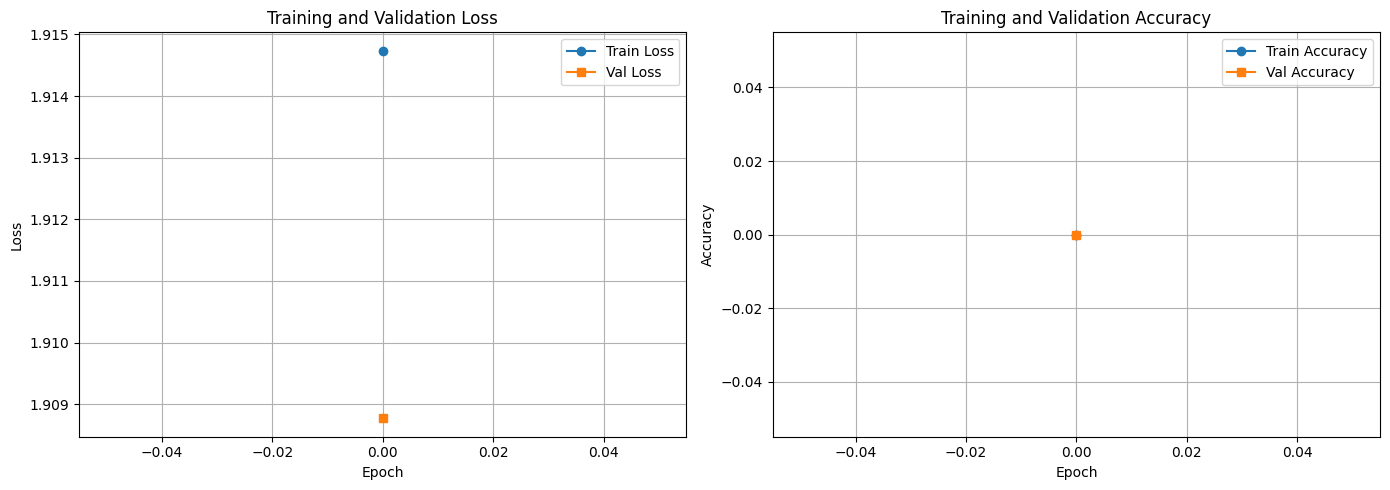


TRAINING SUMMARY
Total epochs: 20
Best validation loss: 1.9088
Final train loss: 1.9147
Final train accuracy: 0.0000
Final val loss: 1.9088
Final val accuracy: 0.0000

Model saved to: ../../checkpoints/final_classification_rnn/classification_rnn_model.pt


In [24]:
# %% Save model
# Build cfg for the best run
best_cfg = {
    "device": device,
    "input_size": input_size,
    "num_classes": n_classes,
    "hidden_size": best_params_cls["hidden_size"],
    "num_layers": best_params_cls["num_layers"],
    "dropout": best_params_cls["dropout"],
    "lr": best_params_cls["lr"],
    "weight_decay": best_params_cls["weight_decay"],
    "batch_size": best_params_cls["batch_size"],
    "epochs": best_params_cls["epochs"],
    "grad_clip": best_params_cls["grad_clip"],
}

# Make loaders & train a final model with best hyperparams
train_loader, val_loader = make_loaders(best_cfg["batch_size"])

model, train_losses, val_losses, train_accs, val_accs = _train_one_run(
    best_cfg, train_loader, val_loader
)

best_val_loss = min(val_losses)

# ==== Save model ====
MODEL_DIR = "../../checkpoints/final_classification_rnn"
os.makedirs(MODEL_DIR, exist_ok=True)
model_path = os.path.join(MODEL_DIR, "classification_rnn_model.pt")
torch.save(model.state_dict(), model_path)
print(f"\nModel saved to: {model_path}")

# ==== Plot training history ====
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(val_accs, label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# ==== Training summary ====
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total epochs: {best_cfg['epochs']}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final train accuracy: {train_accs[-1]:.4f}")
print(f"Final val loss: {val_losses[-1]:.4f}")
print(f"Final val accuracy: {val_accs[-1]:.4f}")
print(f"\nModel saved to: {model_path}")
print("="*60)